# COVID 19 modelling

In this Notebook we'll try and model the COVID 19 virus. As such, let's first get the relevant data. We'll consider Italy. We do this using the API from smartable.

In [1]:
%cd ..

from requests import get

address = 'https://covid19api.herokuapp.com/'
headers = {
    'Content-Type': 'application'
}

data = get(address, headers=headers).json()

/Users/victorgruselius/Documents/GitHub/pyfilter


Next, let's construct a DataFrame with the data.

In [2]:
import pandas as pd

res = dict()

for k in ['confirmed', 'recovered', 'deaths']:
    temp = next(value for value in data[k]['locations'] if value['country_code'] == 'IT')
    
    res[k] = temp['history']

df = pd.DataFrame(res)
df.index = pd.to_datetime(df.index)

Let's plot the data

In [3]:
df.plot(figsize=(16, 9))

Next, we'll need to construct another variable called "susceptible" and normalize to correspond to fractions instead.

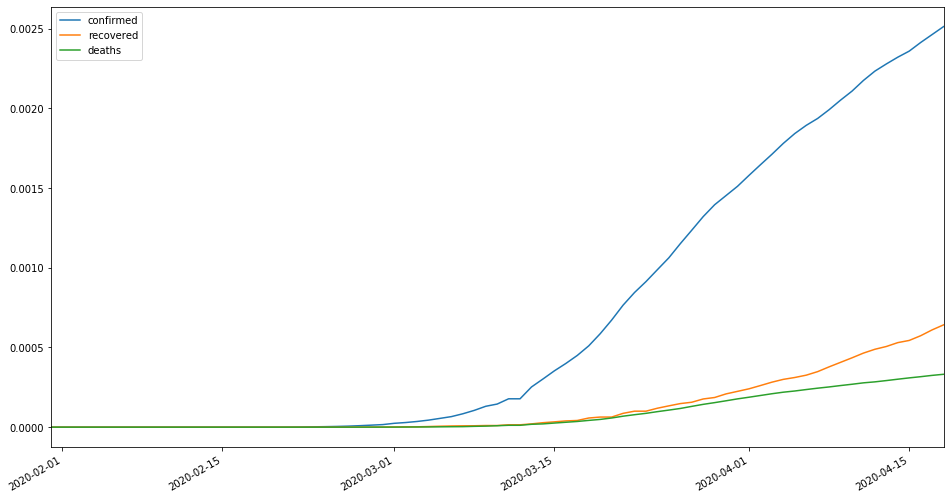

In [4]:
pop = 70e6 # roughly Italian population

df['susceptible'] = pop - df['confirmed'] - df['recovered'] - df['deaths']
mask = df['confirmed'] >= 1

x = df.loc[mask, ['susceptible', 'confirmed', 'recovered', 'deaths']] / pop

x[['confirmed', 'recovered', 'deaths']].plot(figsize=(16, 9))

Next' well model the data. For this exercise we'll a version of the SEIR model incorporating fatality rates, as well as stochastic modelling of some of the rates governing the model, denoting it SEIRD instead. Furthermore, as we're using a SEIRD model, we have no idea of the E part as it's unobserved. Furthermore, let's assume that we only observe a fraction of all the actual infected cases. So, let's model this

In [8]:
from pyfilter.timeseries import TwoFactorSEIRD, LinearGaussianObservations
from torch.distributions import Normal, Independent, TransformedDistribution, PowerTransform, Gamma, AbsTransform, SoftmaxTransform
from pyfilter.filters import SISR
from pyfilter.inference import SMC2
from pyfilter.proposals import Bootstrap
import torch

dist = Independent(
    Normal(
        torch.tensor([0.99, 0., 0.01, 0., 0.]),
        torch.tensor([1e-2, 1e-16, 1e-2, 0., 0.])
    ),
    1
)

folded_normal = TransformedDistribution(dist, [AbsTransform(), SoftmaxTransform()])

print(folded_normal.sample())

# Define the model
invgamma = TransformedDistribution(Gamma(5, 5), PowerTransform(-1.))
hid = TwoFactorSEIRD((invgamma, invgamma, invgamma, 0.05, 0.02, 0., 0.), folded_normal, dt=1e-1)

# Define the observation dynamics
mat = torch.zeros((4, 5))
mat[0, 0] = mat[1, 2] = mat[2, 3] = mat[3, 4] = 1.
# mat[1, 2] *= 0.05

mod = LinearGaussianObservations(hid, mat, 1e-3)

# Perform inference
filt = SISR(mod, 400, proposal=Bootstrap())
alg = SMC2(filt, 1000, threshold=0.5).initialize()

astens = torch.from_numpy(x.values).float()
alg.fit(astens)


SMC2:   0%|          | 0/79 [00:00<?, ?it/s]

tensor([0.4047, 0.1488, 0.1491, 0.1488, 0.1488])



SMC2 - Rejuvenating particles:   0%|          | 0/79 [00:01<?, ?it/s]

RuntimeError: cholesky_cpu: U(1,1) is zero, singular U.

In [ ]:
asdf = pd.DataFrame(alg.filter.filtermeans.mean(dim=1).numpy(), index=x.index, columns=['susceptible', 'exposed', 'confirmed', 'recovered', 'deaths'])

asdf[['confirmed', 'exposed', 'recovered', 'deaths']].plot(figsize=(16, 9))